<a href="https://colab.research.google.com/github/Infor-Mayo/colab_flux/blob/main/flux.1-dev_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Counting objects: 100% (3851/3851), done.
remote: Compressing objects: 100% (307/307), done.
remote: Total 14652 (delta 3693), reused 3544 (delta 3544), pack-reused 10801 (from 1)
Receiving objects: 100% (14652/14652), 22.10 MiB | 24.79 MiB/s, done.
Resolving deltas: 100% (9941/9941), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.1 MB/s eta 0:00:00
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 123623 files and directories currentl

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
!cat /root/.config/ngrok/ngrok.yml
!echo "authtoken: 2oDUgJpSBQDvZ7XRqH8k2WGjyof_52TNeRcKFmQ3q2YD64hMM" > /root/.config/ngrok/ngrok.yml
!cat /root/.config/ngrok/ngrok.yml
!ngrok authtoken "2oDUgJpSBQDvZ7XRqH8k2WGjyof_52TNeRcKFmQ3q2YD64hMM"



authtoken: 2oDUgJpSBQDvZ7XRqH8k2WGjyof_52TNeRcKFmQ3q2YD64hMM
authtoken: 2oDUgJpSBQDvZ7XRqH8k2WGjyof_52TNeRcKFmQ3q2YD64hMM
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Default version saved to configuration file: /root/.config/ngrok/ngrok.yml


In [16]:
!pip install pyngrok
from pyngrok import ngrok
ngrok.kill()
public_url = ngrok.connect(5001)  # Asegúrate de que el puerto sea 5000 o el que estés usando para Flask
print("URL pública:", public_url)



URL pública: NgrokTunnel: "https://983d-34-105-33-125.ngrok-free.app" -> "http://localhost:5001"


copia el primer link en la ventana de la app

In [11]:
texto =""

In [12]:
from flask import Flask, request, jsonify
import threading

app = Flask(__name__)
texto = ""
celda_link = ""


@app.route('/texto', methods=['POST'])
def recibir_texto():
    global texto, celda_link
    data = request.json
    texto = data.get('texto')
    celda_link = data.get('celda_link')  # Captura el enlace de la celda
    print("Texto recibido:", texto)  # Imprime el texto inmediatamente
    print("Link de la celda recibido:", celda_link)  # Imprime el enlace de la celda
    return jsonify({"status": "texto recibido", "contenido": texto, "celda_link": celda_link})


def iniciar_servidor():
    app.run(port=5001)  # Cambia a 5001

threading.Thread(target=iniciar_servidor).start()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit


In [1]:

print(texto)

NameError: name 'texto' is not defined

4789978575841923195


  0%|          | 0/20 [00:00<?, ?it/s]

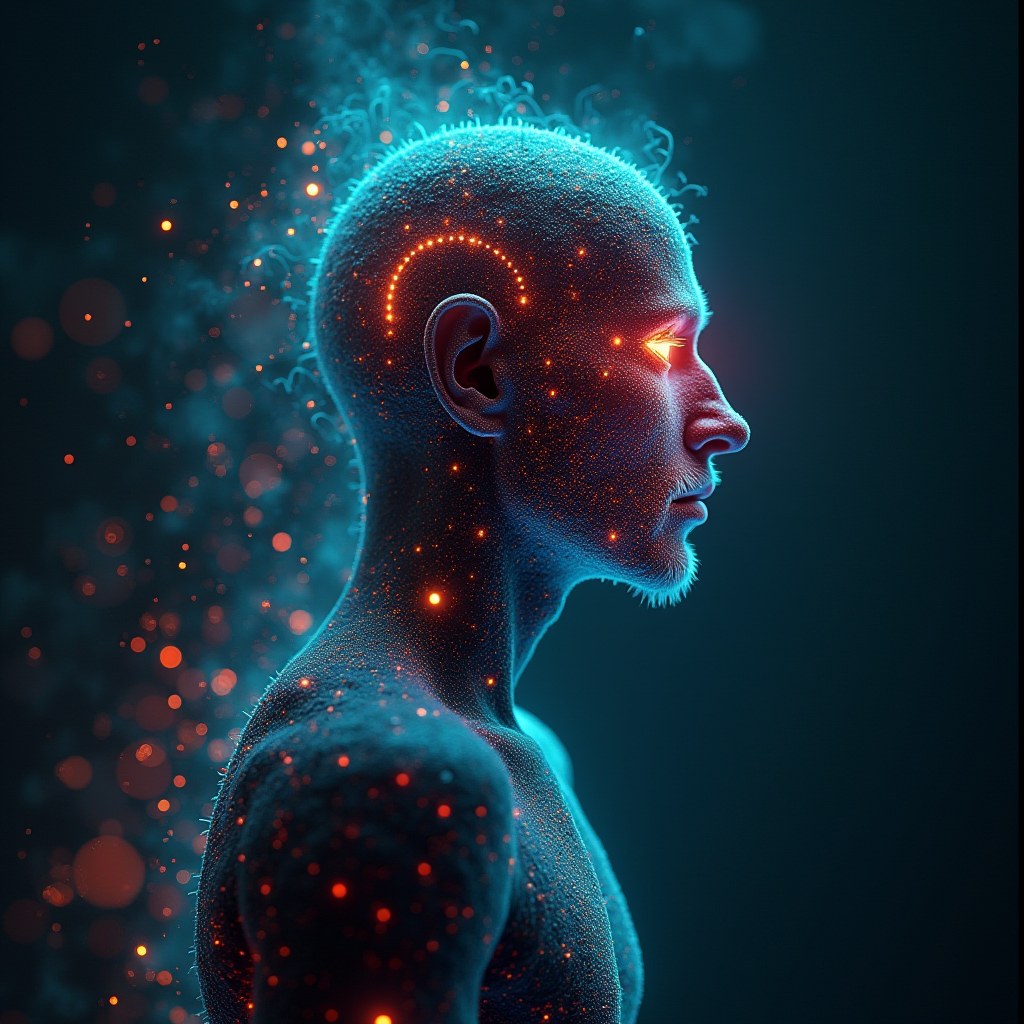

In [ ]:
with torch.inference_mode():
    positive_prompt = texto
    width = 1024
    height = 1024
    seed = 0
    steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])